In [1]:
!pip install datasets transformers evaluate imbalanced-learn umap-learn wandb GPUtil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [119]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

  0%|          | 0/3 [00:00<?, ?it/s]

In [103]:
# Filter out instances with a -1 label
health_fact['train'] = health_fact['train'].filter(lambda x: x['label'] != -1)
health_fact['validation'] = health_fact['validation'].filter(lambda x: x['label'] != -1)
health_fact['test'] = health_fact['test'].filter(lambda x: x['label'] != -1)

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1225 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1235 [00:00<?, ? examples/s]

In [120]:
health_fact.set_format(type="pandas")
df = health_fact["train"][:]
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,"
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health"
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer"
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health"
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,


In [123]:
df.claim_id = pd.to_numeric(df.claim_id, errors='coerce')

df.sort_values('claim_id')[(df.claim_id > 28840) & (df.claim_id < 28870)]

<ipython-input-123-4310bad59c5b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values('claim_id')[(df.claim_id > 28840) & (df.claim_id < 28870)]


,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
5603,28843.0,"""A male penguin searches an entire beach for t...","June 1, 2016",What's true: Male penguins of many species gif...,Kim LaCapria,A popular “Did you know?”-style assertion hold...,,1,"Critter Country, Wild Inaccuracies"
9554,28848.0,"""The Obama administration has proposed revisin...","May 13, 2016",What's true: Proposed revisions to wind power ...,Kim LaCapria,"In early May 2016, a number of alarmist blog p...",,1,"Politics Politicians, bald eagles, barack obam..."
4369,28860.0,"643,000 Americans declare bankruptcy over medi...","April 22, 2016","In short, using some very specific analyses, o...",Kim LaCapria,"In April 2016, a meme was published by the Fac...",,1,"Medical, bankruptcy, medical bankruptcy, meme ..."
7649,28862.0,"""The man leading opposition to a controversial...","April 15, 2016","""What's true: Charlotte businessman Chad Sevea...",Kim LaCapria,"In late February 2016, social media users bega...",,1,"Politics, bathroom bill, bathroom controversie..."
8132,28863.0,Car headrests were deliberately designed to be...,"April 15, 2016",What's true: Car headrests can be used as tool...,Dan Evon,"In April 2016, a message circulated on Faceboo...",http://www.nhtsa.gov/cars/rules/rulings/HeadRe...,1,"Automobiles, Highway Hazards"
6707,28864.0,"Cocktails are a wholly American invention, pop...","April 14, 2016","I actually know where “cocktail” came from, pr...",Brooke Binkowski,The Prohibition era lasted little more than a ...,,1,"Business, American History, cocktail, drinks"
3498,28866.0,Photographs show a white tiger with Down syndr...,"April 13, 2016",What's true: Inbreeding resulted in a white ti...,Dan Evon,Photographs purportedly showing a “tiger with ...,,1,"Fauxtography, animals, down syndrome, kenny"
2601,28867.0,"""An """"abortionist"""" strangled an infant follow...","April 11, 2016",What's true: Dr. William Waddell was tried twi...,Kim LaCapria,"In April 2016, multiple Facebook pages shared ...",,1,"Medical, abortion, abortion horror stories, li..."


In [81]:
def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

In [9]:
df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,label_name
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",false
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",mixture
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",mixture
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",true
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,true


Text(0.5, 1.0, 'Frequency of Classes')

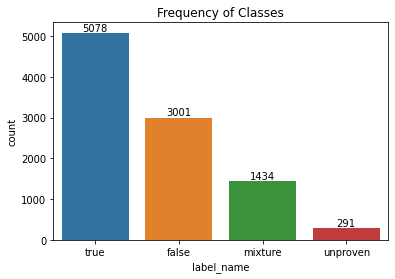

In [10]:
# df["label_name"].value_counts(ascending=True).plot.barh()

ax = sns.countplot(x='label_name', data=df, order = df['label_name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Frequency of Classes")

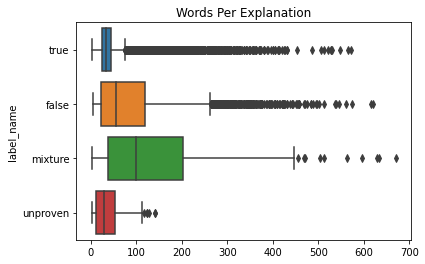

In [11]:
df['Words Per Explanation'] = df['explanation'].str.split().apply(len)
sns.boxplot(x=df['Words Per Explanation'], y=df['label_name'], data=df, order = df['label_name'].value_counts().index)
plt.title("Words Per Explanation")
plt.xlabel("")
plt.show()

In [12]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
# checkpoint = "bert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# tokenized_explanations = tokenizer(health_fact["train"]["explanation"], max_length=512, truncation=True, padding=True, return_tensors="pt")

In [14]:
health_fact.reset_format()

In [15]:
def tokenize(batch):
    return tokenizer(batch['explanation'], truncation=True, padding=True)

In [16]:
health_fact_encoded = health_fact.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/9804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [17]:
print(health_fact_encoded["train"].column_names)

['claim_id', 'claim', 'date_published', 'explanation', 'fact_checkers', 'main_text', 'sources', 'label', 'subjects', 'input_ids', 'attention_mask']


In [18]:
import torch
from transformers import AutoModel

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [20]:
health_fact_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

In [21]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

| ID | GPU | MEM |
------------------
|  0 | 11% |  5% |


In [22]:
del df

In [45]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [46]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()  

| ID | GPU | MEM |
------------------
|  0 |  0% | 14% |


In [25]:
health_fact_hidden = health_fact_encoded.map(extract_hidden_states, batched=True, batch_size=100)

Map:   0%|          | 0/9804 [00:00<?, ? examples/s]

Map:   0%|          | 0/1233 [00:00<?, ? examples/s]

Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [26]:
import numpy as np

X_train = np.array(health_fact_hidden["train"]["hidden_state"])
X_valid = np.array(health_fact_hidden["validation"]["hidden_state"])
y_train = np.array(health_fact_hidden["train"]["label"])
y_valid = np.array(health_fact_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((9804, 768), (1214, 768))

In [27]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,1.561733,0.746110,0
1,8.728687,4.573052,1
2,8.432216,4.876628,1
3,7.584801,3.591166,2
4,7.546659,2.635756,2


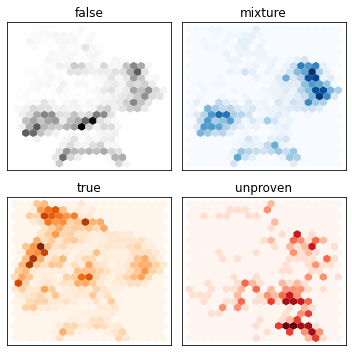

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(5,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Greens"]
labels = health_fact["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6845140032948929

In [30]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5181219110378913

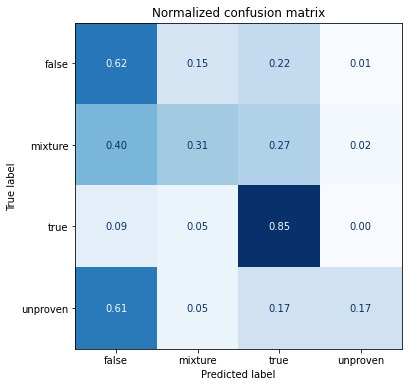

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


In [32]:
from transformers import AutoModelForSequenceClassification

num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [33]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [34]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(health_fact_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-health-fact"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")


In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [36]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  0% | 10% |


In [40]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

class CustomEarlyStoppingCallback(EarlyStoppingCallback):
    def __init__(self, early_stopping_patience=3):
        super().__init__(early_stopping_patience=early_stopping_patience)

early_stopping_callback = CustomEarlyStoppingCallback(early_stopping_patience=1)
        
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=health_fact_encoded["train"],
                  eval_dataset=health_fact_encoded["validation"],
                  tokenizer=tokenizer,
                  callbacks=[early_stopping_callback],)
# trainer.train();

In [42]:
trainer

In [47]:
preds_output = trainer.predict(health_fact_encoded["validation"])


In [48]:
preds_output.metrics

{'test_loss': 0.6748207807540894,
 'test_accuracy': 0.7347611202635914,
 'test_f1': 0.717243286501757,
 'test_runtime': 19.3725,
 'test_samples_per_second': 62.666,
 'test_steps_per_second': 1.962}

In [49]:
y_preds = np.argmax(preds_output.predictions, axis=1)


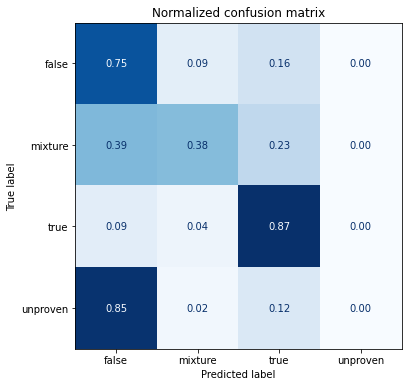

In [50]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [51]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [52]:
# Convert our dataset back to PyTorch tensors
health_fact_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
health_fact_encoded["validation"] = health_fact_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/1214 [00:00<?, ? examples/s]

In [87]:
health_fact_encoded.set_format("pandas")
cols = ["claim", "explanation", "label", "predicted_label", "loss", "date_published", "claim_id"]
df_test = health_fact_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [88]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

df_test['claim'] = df_test['claim'].str.wrap(30)
df_test['explanation'] = df_test['explanation'].str.wrap(30)
wrap_df_text(df_test.sort_values("loss", ascending=False).head(10))


,claim,explanation,label,predicted_label,loss,date_published,claim_id
631,Viral image Says Harvardscientists say the coronavirusis “spreading so fast that itwill infect 70% of humanitythis year.”,An epidemiologist at HarvardUniversity projects 40%-70% ofadults could catch coronavirusin the coming year.,mixture,true,4.788632,"March 11, 2020",26702
531,"Russia used ""GPS spoofing"" tocause the USS John McCain tocollide with a merchantvessel.","In the wake of the USS McCaincollision, the chief of NavalOperations “ordered aworldwide operational pause asfleet commanders assesspractices.”",unproven,true,4.595818,"August 22, 2017",34361
249,FDA Approves Cystic FibrosisDrug,Firefighters battlingwildfires in Australia madethe most of cooler weather onSunday to access badly burnedtowns and contain blazesbefore the expected return ofhotter conditions at the endof the week.,mixture,true,4.508622,"February 1, 2012",9810
9,Results mixed on Merck’s newpainkiller,"Ethical investors, includingthe Church of England, plan toextend their campaign forminers and other bigbusinesses to stop fundingindustry associations thatblock progress on U.N. goalsto curb climate change, theysaid on Tuesday.",mixture,true,4.434467,"November 13, 2006",11514
987,"A treatment for a seriousdisease that costs $900 inIndia is sold for $84,000 inthe United States because ofcorporate greed.","A French court has ruled thatMonsanto was liable for thesickness of a farmer whoinhaled one of itsweedkillers, in another legalsetback for the Bayer-ownedbusiness over health claims.",mixture,true,4.389694,"May 2, 2016",28855
339,The race to create a new classof ovarian cancer drugs heatsup,"Boeing Co’s Starlinerastronaut spacecraft landed inthe New Mexico desert onSunday, the company said,after faulty software forcedofficials to cut short anunmanned mission aimed attaking it to the InternationalSpace Station.",mixture,true,4.266823,"October 14, 2016",9553
790,Eating more vegetable proteinmay protect against earlymenopause,Australian officials tookadvantage of better weather onMonday to reopen roads blockedby wildfires and move somepeople to safety althoughthick smoke stalled rescueefforts and hundreds of peopleremained stranded.,mixture,true,4.159300,"June 28, 2017",9128
904,"We have no [trade] deficit[with Canada], but thatdoesn't include energy andtimber. But when you do welose $17 billion a year.""","This Sunday in South Africa,an accountant, an entrepreneurand a boxing executive areamong 20 friends running theCape Town marathon - withsaplings strapped to theirbacks.",false,true,3.958422,"March 15, 2018",41939
544,The Tim Allen show 'Last ManStanding' was cancelled due tothe star's political beliefs.,"In May 2018, Fox announcedthey would be bringing backLast Man Standing for the2018-19 television season.",unproven,true,3.743434,"May 18, 2017",34403
1128,Marijuana dealers are usingthe popular game app PokémonGO to hook children on drugs.,"The number of people missingafter California’s deadliestand most destructive wildfirejumped on Saturday to 1,276,despite authorities locatinghundreds of people whoscattered when the Camp Firetore through the mountain townof Paradise.",false,true,3.711048,"August 10, 2016",32411


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   claim_id        9804 non-null   object
 1   claim           9804 non-null   object
 2   date_published  9804 non-null   object
 3   explanation     9804 non-null   object
 4   fact_checkers   9804 non-null   object
 5   main_text       9804 non-null   object
 6   sources         9804 non-null   object
 7   label           9804 non-null   int64 
 8   subjects        9804 non-null   object
 9   label_name      9804 non-null   object
dtypes: int64(1), object(9)
memory usage: 766.1+ KB


In [125]:
# df[df.claim.str.startswith("A treatment for a serious disease")]
val_df = health_fact["validation"][:]
val_df[val_df.claim_id == '28855']

val_df['claim'] = val_df['claim'].str.wrap(30)
val_df['explanation'] = val_df['explanation'].str.wrap(30)
wrap_df_text(val_df[val_df.claim_id == '28855'])


,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects
997,28855,"A treatment for a seriousdisease that costs $900 inIndia is sold for $84,000 inthe United States because ofcorporate greed.","May 2, 2016","A French court has ruled thatMonsanto was liable for thesickness of a farmer whoinhaled one of itsweedkillers, in another legalsetback for the Bayer-ownedbusiness over health claims.",Brooke Binkowski,"In the latest stage of a decade-long legal tussle, the appeals court in Lyon on Thursday found in favor of farmer Paul Francois’ claim that Monsanto’s Lasso weedkiller had made him sick and that the product’s labeling had been inadequate. Francois, 55, says he suffered neurological problems, including memory loss, fainting and headaches, after accidentally inhaling Lasso in 2004 while working on his farm. “Mr Francois justifiably concludes that the product, due to its inadequate labeling that did not respect applicable regulations, did not offer the level of safety he could legitimately expect,” the court said in its ruling. The latest verdict, however, did not determine compensation for the farmer, which will now be considered by another court in Lyon. Francois is seeking about 1 million euros ($1.1 million) in damages. Bayer, which acquired Monsanto in a $63 billion deal last year, said it was considering its legal options, including an appeal before France’s highest court. The German chemicals group added that crop-protection products “do not pose a risk for human health if they are used according to the terms of use set out in their regulatory approval”. Mr Francois had won rulings against Monsanto in 2012 and 2015 before France’s top court overturned the decisions and ordered the new hearing in Lyon. “We are all happy to have won but it came at a heavy price,” Francois told reporters in Paris. “It’s a big sigh of relief. It’s been 12 years of fighting, 12 years during which I had to put my whole life on hold.” Lasso was banned in France in 2007 after the product had been withdrawn in some other countries. It used a different active substance to glyphosate, the chemical contained in Monsanto’s best-selling weedkiller Roundup and the target of lawsuits in the United States over alleged cancer links. The company has been found liable in two trials in California brought by cancer sufferers who have been awarded tens of millions of dollars in damages. Bayer is appealing against those rulings. The legal troubles surrounding glyphosate have contributed to Bayer losing about 30 billion euros in market value since last August. The group’s chief executive on Thursday said it was “massively affected” by the litigation. After the announcement of the decision, Bayer’s shares extended a fall to trade about 1.5 percent down before recovering some of the losses. ($1 = 0.8874 euros)","http://www.wsj.com/articles/why-the-u-s-pays-more-than-other-countries-for-drugs-1448939481, https://aspe.hhs.gov/sites/default/files/pdf/76521/ib.pdf, http://www.cdc.gov/hepatitis/hcv/, http://www.cnbc.com/2016/03/25/gilead-ordered-to-pay-merck-200m-for-patent-infringement.html",1,"Medical, american health care system, big pharma, corporate greed"


In [67]:
wrap_df_text(df_test.sort_values("loss", ascending=True).head(10))

,claim,explanation,label,predicted_label,loss
533,Senate panel: NY needsaddiction treatmentprofessionals.,A New York state Senate panelis recommending the state domore to recruit and trainhealth care professionals whowork with recovering addicts.,true,true,0.024065
994,Task force offers guidelinesto treat rat lungworm disease.,"A task force of HawaiiGovernor David Ige’s announcednew preliminary guidelines tohelp physicians diagnose,treat and manage rat lungwormdisease.",true,true,0.024436
112,Health officials warn ofpossible Legionnaires’exposure.,Health officials are warningof a potential forLegionnaires’ disease exposureat an outpatient cancer centerin Springfield.,true,true,0.025118
33,Alabama: Case of meningococcaldisease in Jackson County.,"The Alabama Department ofPublic Health’s ImmunizationDivision is investigating acase of meningococcal disease,the leading cause of bacterialmeningitis in children betweenthe ages of 2 and 18 in theUnited States.",true,true,0.025154
1211,Officials probe respiratoryillness at Quincy veterans’home.,State officials areinvestigating several cases ofcommunicable respiratoryillness at the same state-runveterans’ home in Quincy wherethere have been multipleoutbreaks of LegionnairesDisease over the years.,true,true,0.025383
1104,South Dakota plans masstesting in elder carefacilities.,"South Dakota health officialsare planning to test everyonein nursing homes and assistedliving facilities over thenext month, Gov. Kristi Noemannounced Thursday.",true,true,0.025755
1143,Governor works withbroadcasters to address mentalhealth.,Rhode Island’s governor andher husband are joining withlocal broadcasters to launch amental health awarenesscampaign.,true,true,0.025904
538,Brain-dead California girlordered kept on ventilator forweek longer.,The family of a Californiagirl who was declared braindead after complications froma tonsillectomy won an 11th-hour court order on Mondayrequiring doctors to keep herconnected to a breathingmachine for at least anotherweek.,true,true,0.025909
312,"Hepatitis A confirmed atRedfield, Arkansas, diner.",Health officials are againwarning of a possiblehepatitis A exposure after anemployee at a central Arkansasdiner tested positive for thedisease.,true,true,0.026084
736,Medical school get $3.7M toaddress geriatric careshortage.,"The University of NebraskaMedical Center has received afive-year, $3.7 million grantto address the loomingshortage of doctors whospecialize in the care ofolder adults.",true,true,0.026134


In [38]:
import wandb
wandb.init(project="pubhealth-hyperparameter-search")

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁███
train/global_step,▁▁███
train/learning_rate,█▁
train/loss,█▁
train/total_flos,▁


In [41]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
num_labels=4
# Define the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Function to train and evaluate the model with given hyperparameters
def train_evaluate_model(learning_rate, batch_size, weight_decay, warmup_step):
    model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=4,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_steps=warmup_step,
        logging_dir='./logs',
        logging_steps=100,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        report_to="wandb",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model, 
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=health_fact_encoded["train"],
        eval_dataset=health_fact_encoded["validation"],
        tokenizer=tokenizer,
        callbacks=[CustomEarlyStoppingCallback(early_stopping_patience=1)],
    )

    # Train the model
    trainer.train()
    
    # would be good to run the below up front to check that this actually works ...

    # Evaluate the model on the validation set
    results = trainer.evaluate(health_fact_encoded["validation"])
    
    summary = {
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "warmup_step": warmup_step,
        "accuracy": results["eval_accuracy"],
    }
    print(summary)
    # Log the hyperparameters and results in wandb
    wandb.log(summary)

# Perform hyperparameter search
learning_rates = [1e-5, 5e-5, 9e-5]
batch_sizes = [32, 64]
weight_decays = [0.02, 0.05]
warmup_steps = [0, 500]

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for weight_decay in weight_decays:
            for warmup_step in warmup_steps:
                train_evaluate_model(learning_rate, batch_size, weight_decay, warmup_step)


# Close wandb
wandb.finish()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.0277, 'learning_rate': 9.185667752442996e-06, 'epoch': 0.33}
{'loss': 0.8563, 'learning_rate': 8.371335504885994e-06, 'epoch': 0.65}
{'loss': 0.7838, 'learning_rate': 7.557003257328991e-06, 'epoch': 0.98}
{'eval_loss': 0.7576387524604797, 'eval_accuracy': 0.6729818780889621, 'eval_f1': 0.6689134046258527, 'eval_runtime': 19.3821, 'eval_samples_per_second': 62.635, 'eval_steps_per_second': 1.961, 'epoch': 1.0}
{'loss': 0.742, 'learning_rate': 6.7426710097719875e-06, 'epoch': 1.3}
{'loss': 0.7183, 'learning_rate': 5.928338762214985e-06, 'epoch': 1.63}
{'loss': 0.6883, 'learning_rate': 5.114006514657981e-06, 'epoch': 1.95}
{'eval_loss': 0.7060016989707947, 'eval_accuracy': 0.71334431630972, 'eval_f1': 0.6923690811673494, 'eval_runtime': 19.4009, 'eval_samples_per_second': 62.575, 'eval_steps_per_second': 1.959, 'epoch': 2.0}
{'loss': 0.6613, 'learning_rate': 4.299674267100978e-06, 'epoch': 2.28}
{'loss': 0.6238, 'learning_rate': 3.4853420195439743e-06, 'epoch': 2.61}
{'loss': 0

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.3139, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.33}
{'loss': 1.0532, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.65}
{'loss': 0.8857, 'learning_rate': 6e-06, 'epoch': 0.98}
{'eval_loss': 0.8055453896522522, 'eval_accuracy': 0.671334431630972, 'eval_f1': 0.6539888370236516, 'eval_runtime': 19.3706, 'eval_samples_per_second': 62.672, 'eval_steps_per_second': 1.962, 'epoch': 1.0}
{'loss': 0.8032, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.3}
{'loss': 0.7639, 'learning_rate': 1e-05, 'epoch': 1.63}
{'loss': 0.723, 'learning_rate': 8.626373626373628e-06, 'epoch': 1.95}
{'eval_loss': 0.7514588832855225, 'eval_accuracy': 0.6919275123558485, 'eval_f1': 0.6632738052583348, 'eval_runtime': 19.3509, 'eval_samples_per_second': 62.736, 'eval_steps_per_second': 1.964, 'epoch': 2.0}
{'loss': 0.6817, 'learning_rate': 7.252747252747253e-06, 'epoch': 2.28}
{'loss': 0.6379, 'learning_rate': 5.8791208791208794e-06, 'epoch': 2.61}
{'loss': 0.6624, 'learning_rate': 4.50549

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.9999, 'learning_rate': 9.185667752442996e-06, 'epoch': 0.33}
{'loss': 0.8416, 'learning_rate': 8.371335504885994e-06, 'epoch': 0.65}
{'loss': 0.7689, 'learning_rate': 7.557003257328991e-06, 'epoch': 0.98}
{'eval_loss': 0.7451725006103516, 'eval_accuracy': 0.699341021416804, 'eval_f1': 0.6946644955382438, 'eval_runtime': 19.4529, 'eval_samples_per_second': 62.407, 'eval_steps_per_second': 1.953, 'epoch': 1.0}
{'loss': 0.7266, 'learning_rate': 6.7426710097719875e-06, 'epoch': 1.3}
{'loss': 0.7091, 'learning_rate': 5.928338762214985e-06, 'epoch': 1.63}
{'loss': 0.6805, 'learning_rate': 5.114006514657981e-06, 'epoch': 1.95}
{'eval_loss': 0.7112392783164978, 'eval_accuracy': 0.7100494233937397, 'eval_f1': 0.6907801550535185, 'eval_runtime': 19.341, 'eval_samples_per_second': 62.768, 'eval_steps_per_second': 1.965, 'epoch': 2.0}
{'loss': 0.6565, 'learning_rate': 4.299674267100978e-06, 'epoch': 2.28}
{'loss': 0.6213, 'learning_rate': 3.4853420195439743e-06, 'epoch': 2.61}
{'loss': 

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.3139, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.33}
{'loss': 1.0532, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.65}
{'loss': 0.8857, 'learning_rate': 6e-06, 'epoch': 0.98}
{'eval_loss': 0.8056472539901733, 'eval_accuracy': 0.671334431630972, 'eval_f1': 0.6542194075906173, 'eval_runtime': 19.3948, 'eval_samples_per_second': 62.594, 'eval_steps_per_second': 1.959, 'epoch': 1.0}
{'loss': 0.8032, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.3}
{'loss': 0.7639, 'learning_rate': 1e-05, 'epoch': 1.63}
{'loss': 0.723, 'learning_rate': 8.626373626373628e-06, 'epoch': 1.95}
{'eval_loss': 0.7505345344543457, 'eval_accuracy': 0.6902800658978583, 'eval_f1': 0.6614554002477303, 'eval_runtime': 19.3369, 'eval_samples_per_second': 62.781, 'eval_steps_per_second': 1.965, 'epoch': 2.0}
{'loss': 0.6816, 'learning_rate': 7.252747252747253e-06, 'epoch': 2.28}
{'loss': 0.638, 'learning_rate': 5.8791208791208794e-06, 'epoch': 2.61}
{'loss': 0.6624, 'learning_rate': 4.505494

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


OutOfMemoryError: ignored

In [ ]:
# from transformers import AutoModelForSequenceClassification
# from transformers import Trainer, TrainingArguments
# num_labels=4
# # Define the model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# def main(verbose=False):
#     # Initialise run
#     run = wandb.init()
#     model = (AutoModelForSequenceClassification
#          .from_pretrained(model_ckpt, num_labels=num_labels)
#          .to(device))

#     training_args = TrainingArguments(
#         output_dir='./results',
#         num_train_epochs=4,
#         per_device_train_batch_size=wandb.config.batch_size,
#         per_device_eval_batch_size=wandb.config.batch_size,
#         learning_rate=wandb.config.learning_rate,
#         weight_decay=wandb.config.weight_decay,
#         dropout_rate=wandb.config.dropout_rate,
#         logging_dir='./logs',
#         logging_steps=100,
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         save_total_limit=1,
#         report_to="wandb",
#         load_best_model_at_end=True,
#         metric_for_best_model="accuracy",
#         greater_is_better=True,
#         patience=1,  # Number of epochs with no improvement after which training will be stopped
#     )

#     trainer = Trainer(
#         model=model, 
#         args=training_args,
#         compute_metrics=compute_metrics,
#         train_dataset=health_fact_encoded["train"],
#         eval_dataset=health_fact_encoded["validation"],
#         tokenizer=tokenizer
#     )

#     # Train the model
#     trainer.train()

#     # Evaluate the model on the validation set
#     results = trainer.evaluate(health_fact_encoded["validation"])

#     # Log the hyperparameters and results in wandb
#     wandb.log({
#         "learning_rate": learning_rate,
#         "batch_size": batch_size,
#         "weight_decay": weight_decay,
#         "dropout_rate": dropout_rate,
#         "accuracy": results["eval_accuracy"],
#     })

In [ ]:
# sweep_configuration = {
#     'method': 'bayes',  # random, grid or bayes
#     'name': 'sweep-bayes',
#     'metric': {'goal': 'maximize', 'name': 'eval_accuracy'},
#     'parameters': 
#     {
#         'batch_size': {'values': [8, 16, 32]},
#         'learning_rate': {'max': 0.1, 'min': 0.0001},
#         'weight_decay': {'values': [0.0, 0.1, 0.2]},
#         'dropout_rate': {'max': 0.5, 'min': 0.1}
#      }
# }

In [ ]:
# sweep_id = wandb.sweep(sweep=sweep_configuration, entity='tansaku', project='pubhealth-hyperparameter-search')

In [ ]:
# # Maximum 'count' runs
# wandb.agent(sweep_id, function=main, count=2)